In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xset = np.load('../1-prepro/xset.npy')
yset = np.load('../1-prepro/yset.npy')

xset.shape, yset.shape

((34120, 2, 3750), (34120,))

In [3]:
def get_y(yset):
    
    outs=[]
    for y in yset:
        if y >=65: out = 2
        if (y>40) & (y<65): out= 1
        if y <40: out=0
        outs.append(out)
    outs = np.array(outs)
    return outs


In [4]:
data_y = get_y(yset)

In [5]:
def plot_data_dist(x):
    x = x.reshape(x.shape[0]*x.shape[1])
    x[x>100]=100
    x[x<-100]=-100
    x = x.reshape(len(x), 1)
    plt.hist(x, bins=50, alpha=0.5)
    return x
from sklearn.preprocessing import StandardScaler 
def plot_scaled_dist(x):
    scaler = StandardScaler()
    scaler.fit(x)
    scaled = scaler.transform(x)
    plt.hist(scaled, bins=50, alpha=0.5)

    return scaled

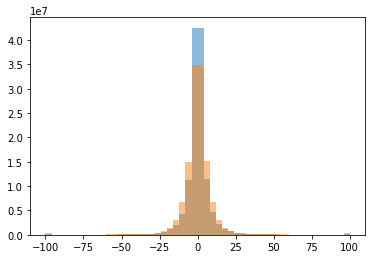

In [6]:
x0 = plot_data_dist(xset[:,0])
x1 = plot_data_dist(xset[:,1])

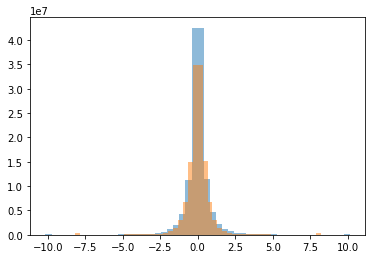

In [7]:
x0 = plot_scaled_dist(x0)
x1 = plot_scaled_dist(x1)

In [15]:
#x0_ = x0.reshape(34120, 1, 3750)
#x1_ = x1.reshape(34120, 1, 3750)
x0_ = x0.reshape(34120, 3750, 1)
x1_ = x1.reshape(34120, 3750, 1)
x0_.shape, x1_.shape

((34120, 3750, 1), (34120, 3750, 1))

In [16]:
data_x = np.concatenate((x0_, x1_), axis=2)
data_x.shape

(34120, 3750, 2)

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((27296, 3750, 2), (6824, 3750, 2), (27296,), (6824,))

In [18]:
import tensorflow as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.layers import Dense, Input, Bidirectional, Dropout, Masking
from tensorflow.keras.layers import LSTM, BatchNormalization, Activation


def build_model(x_shape):
    
    
    model = Sequential()
    
    model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(x_shape[1],x_shape[2])))
    model.add(Bidirectional(LSTM(64)))

    model.add(Dense(3, activation='softmax'))
 

    model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [19]:
x_train.shape, y_train.shape

((27296, 3750, 2), (27296,))

In [20]:
model = build_model(x_train.shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 3750, 512)         530432    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               295424    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 826,243
Trainable params: 826,243
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class_weights = np.array([0.68741815, 0.8576366 , 4.63653047])
history = model.fit(x_train, y_train , 
                    batch_size=64, epochs=5, 
                    validation_split=0.2,
                    class_weight=class_weights
                   
)

Train on 21836 samples, validate on 5460 samples
Epoch 1/5
   64/21836 [..............................] - ETA: 4:23:20 - loss: 1.0937 - accuracy: 0.4688

In [39]:
model.evaluate(x_test, y_test)

6824/6824 [==============================] - 3s 449us/sample - loss: 2.5434 - accuracy: 0.5935


[2.543436414820927, 0.5934936]

In [40]:
y_pred = model.predict_classes(x_test)
y_pred

array([2, 0, 0, ..., 1, 0, 0])

Text(33.0, 0.5, 'True')

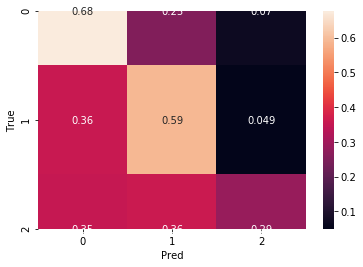

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel("Pred")
ax.set_ylabel("True")

In [42]:
cm

array([[0.6756267 , 0.25430384, 0.07006947],
       [0.35889686, 0.59161315, 0.04948999],
       [0.35334873, 0.36143187, 0.2852194 ]])

In [16]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

/Users/nibey/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[1 0 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
